In [1]:
import numpy as np
import utils
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
import multiprocessing as mp
import matplotlib.pyplot as plt

In [2]:

def load_data(filename, p_train):
    """Load a dataset CSV, shuffle, and split into train and test."""
    data = np.loadtxt(filename, delimiter=',', skiprows=1)
    n_train = int(p_train*len(data))
    
    np.random.shuffle(data)
    X, y = data[:, :-1], data[:, -1]
    scaler = StandardScaler()
    scaler.fit(X[:n_train])
    X = scaler.transform(X)

    X_train, X_test = X[:n_train], X[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]
    return X_train, X_test, y_train, y_test



def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return [query_idx], X_pool[query_idx]


def run_exp_us(intup):
    global X_train, X_test, y_train, y_test, query_budget, n_seed
    rep, i, p, v = intup

    # Make noisy data, simulate pool-based case
    X_train_noisy = utils.add_gaussian_noise(X_train, v)
    y_train_noisy = utils.flip_labels(y_train, p)
    seed = np.random.choice(range(len(X_train_noisy)), n_seed, replace=False)
    other = list(set(range(len(X_train_noisy))) - set(seed))
    X_seed, X_pool = X_train_noisy[seed], X_train_noisy[other]
    y_seed, y_pool = y_train_noisy[seed], y_train_noisy[other]

    # Initializing the learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(n_estimators=10),
        query_strategy=uncertainty_sampling,
        X_training=X_seed, y_training=y_seed
    )

    # Run active learning and record history of test accuracy
    history = np.zeros(query_budget - n_seed)
    for j in range(query_budget - n_seed):
        query_idx, query_inst = learner.query(X_pool)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        history[j] = learner.score(X_test, y_test)
    return history

def run_exp_rs(intup):
    global X_train, X_test, y_train, y_test, query_budget, n_seed
    rep, i, p, v = intup

    # Make noisy data, simulate pool-based case
    X_train_noisy = utils.add_gaussian_noise(X_train, v)
    y_train_noisy = utils.flip_labels(y_train, p)
    seed = np.random.choice(range(len(X_train_noisy)), n_seed, replace=False)
    other = list(set(range(len(X_train_noisy))) - set(seed))
    X_seed, X_pool = X_train_noisy[seed], X_train_noisy[other]
    y_seed, y_pool = y_train_noisy[seed], y_train_noisy[other]

    # Initializing the learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(n_estimators=10),
        query_strategy=random_sampling,
        X_training=X_seed, y_training=y_seed
    )

    # Run active learning and record history of test accuracy
    history = np.zeros(query_budget - n_seed)
    for j in range(query_budget - n_seed):
        query_idx, query_inst = learner.query(X_pool)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        history[j] = learner.score(X_test, y_test)
    return history

In [3]:
np.random.seed(165)
dataset = 'wdbc_data.csv'
X_train, X_test, y_train, y_test = load_data(dataset, 0.7)
n_seed = 10
query_budget = 50
reps = 1000

# Noisy labels

In [4]:
ps = [0, 0.1, 0.2, 0.3, 0.4]
log_interval = 10
us_results = np.zeros((reps, len(ps), query_budget - n_seed))

rtup = []
for rep in range(reps):
    for i, p in enumerate(ps):
        rtup.append((rep, i, p, 0))

pool = Pool(mp.cpu_count() - 2)
histories = pool.map(run_exp_us, rtup)

for it in range(len(rtup)):
    rep, i, p, v = rtup[it]
    us_results[rep, i] = histories[it] 


# tags = list(map(lambda p: 'var=' + str(p), ps))
# results = np.mean(all_results, axis=0)

# utils.plot_learning_curves(results, range(n_seed + 1, query_budget + 1),
#                            tags, '{}_synthetic_noisy_labels.png'.format(dataset.split('.')[0]))

In [5]:
ps = [0, 0.1, 0.2, 0.3, 0.4]
log_interval = 10
rs_results = np.zeros((reps, len(ps), query_budget - n_seed))

rtup = []
for rep in range(reps):
    for i, p in enumerate(ps):
        rtup.append((rep, i, p, 0))

pool = Pool(mp.cpu_count() - 2)
histories = pool.map(run_exp_rs, rtup)

for it in range(len(rtup)):
    rep, i, p, v = rtup[it]
    rs_results[rep, i] = histories[it] 

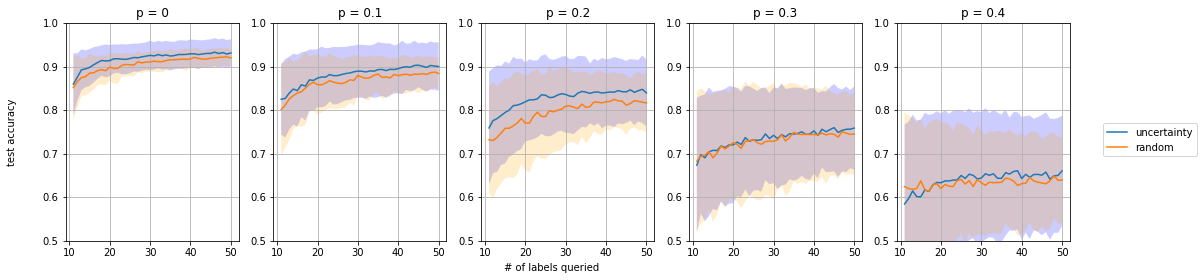

In [6]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(18, 4)
x = range(n_seed + 1, query_budget + 1)
for i, p in enumerate(ps):
    ax[i].set_ylim(0.5,1.0)
#     plt.xlabel('# of labels queried')
#     plt.ylabel(ylabel)
    ax[i].grid()
    ax[i].set_title('p = ' + str(p))
    us_avg = np.mean(us_results[:, i, :], axis=0)
    us_std = np.std(us_results[:, i, :], axis=0)
    ax[i].fill_between(x, us_avg - us_std, us_avg + us_std, facecolor='blue', alpha=0.2)
    ax[i].plot(x, us_avg, label='uncertainty')
    rs_avg = np.mean(rs_results[:, i, :], axis=0)
    rs_std = np.std(rs_results[:, i, :], axis=0)
    ax[i].fill_between(x, rs_avg - rs_std, rs_avg + rs_std, facecolor='orange', alpha=0.2)
    ax[i].plot(x, rs_avg, label='random')
fig.text(0.5, 0.02, '# of labels queried', ha='center')
fig.text(0.08, 0.5, 'test accuracy', va='center', rotation='vertical')
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right')

# Noisy features

In [7]:
vs = [0, 0.5, 1.0, 1.5, 2.0]
log_interval = 10
us_results = np.zeros((reps, len(vs), query_budget - n_seed))

rtup = []
for rep in range(reps):
    for i, v in enumerate(vs):
        rtup.append((rep, i, 0, v))

pool = Pool(mp.cpu_count() - 2)
histories = pool.map(run_exp_us, rtup)

for it in range(len(rtup)):
    rep, i, p, v = rtup[it]
    us_results[rep, i] = histories[it] 


# tags = list(map(lambda p: 'var=' + str(p), ps))
# results = np.mean(all_results, axis=0)

# utils.plot_learning_curves(results, range(n_seed + 1, query_budget + 1),
#                            tags, '{}_synthetic_noisy_labels.png'.format(dataset.split('.')[0]))

In [8]:
vs = [0, 0.5, 1.0, 1.5, 2.0]
log_interval = 10
rs_results = np.zeros((reps, len(vs), query_budget - n_seed))

rtup = []
for rep in range(reps):
    for i, v in enumerate(vs):
        rtup.append((rep, i, 0, v))

pool = Pool(mp.cpu_count() - 2)
histories = pool.map(run_exp_rs, rtup)

for it in range(len(rtup)):
    rep, i, p, v = rtup[it]
    rs_results[rep, i] = histories[it] 

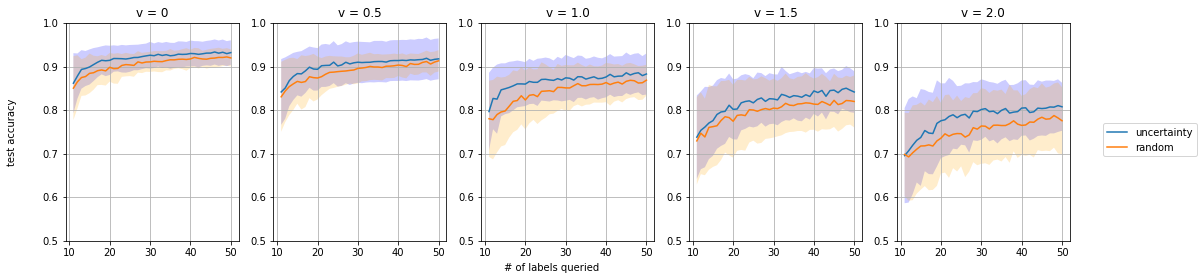

In [9]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(18, 4)
x = range(n_seed + 1, query_budget + 1)
for i, v in enumerate(vs):
    ax[i].set_ylim(0.5, 1.0)
#     plt.xlabel('# of labels queried')
#     plt.ylabel(ylabel)
    ax[i].grid()
    ax[i].set_title('v = ' + str(v))
    us_avg = np.mean(us_results[:, i, :], axis=0)
    us_std = np.std(us_results[:, i, :], axis=0)
    ax[i].fill_between(x, us_avg - us_std, us_avg + us_std, facecolor='blue', alpha=0.2)
    ax[i].plot(x, us_avg, label='uncertainty')
    rs_avg = np.mean(rs_results[:, i, :], axis=0)
    rs_std = np.std(rs_results[:, i, :], axis=0)
    ax[i].fill_between(x, rs_avg - rs_std, rs_avg + rs_std, facecolor='orange', alpha=0.2)
    ax[i].plot(x, rs_avg, label='random')
fig.text(0.5, 0.02, '# of labels queried', ha='center')
fig.text(0.08, 0.5, 'test accuracy', va='center', rotation='vertical')
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right')